In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [439]:
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [440]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [446]:
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]
rate.head()

,0
2011.01,10.2
2011.02,10.2
2011.03,10.2
2011.04,10.2
2011.05,10.2


In [672]:
folder = os.listdir()

file = []
for f in folder:
    if "_2022" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
# gajwa = gajwa.dropna(axis=0)

geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "8"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명


#원핫인코딩으로 전월세 구분하기
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])
# gajwa = pd.get_dummies(gajwa, columns = ["도로명"])

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)

gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,8,12.00,202003,5,1500,25,2007,진주대로404번길,128.105889,35.157466,2020,3,경상남도 진주시 가좌동 진주대로404번길,1,0,4.8,7750
1,경상남도 진주시 가좌동,1***,8,15.00,202003,11,500,40,2016,가좌길78번길,128.105857,35.157800,2020,3,경상남도 진주시 가좌동 가좌길78번길,1,0,4.8,10500
5,경상남도 진주시 가좌동,5**,12,19.80,202003,14,200,36,2011,내동로348번길,128.106121,35.158214,2020,3,경상남도 진주시 가좌동 내동로348번길,1,0,4.8,9200
6,경상남도 진주시 가좌동,1***,8,20.00,202003,26,300,30,2016,가좌길48번길,128.105857,35.157800,2020,3,경상남도 진주시 가좌동 가좌길48번길,1,0,4.8,7800
7,경상남도 진주시 가좌동,1***,12,20.10,202003,8,300,30,2014,진주대로404번길,128.105966,35.156961,2020,3,경상남도 진주시 가좌동 진주대로404번길,1,0,4.8,7800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,경상남도 진주시 가좌동,1***,8,25.00,202011,28,5000,0,2017,진주대로404번길,128.105857,35.157800,2020,11,경상남도 진주시 가좌동 진주대로404번길,0,1,4.7,5000
3167,경상남도 진주시 가좌동,5**,12,30.00,202011,24,300,37,2007,진주대로500번길,128.108498,35.154904,2020,11,경상남도 진주시 가좌동 진주대로500번길,1,0,4.7,9747
3168,경상남도 진주시 가좌동,1***,8,30.00,202011,27,2000,20,2019,내동로320번길,128.107180,35.162495,2020,11,경상남도 진주시 가좌동 내동로320번길,1,0,4.7,7106
3169,경상남도 진주시 가좌동,1***,12,36.30,202011,26,300,55,1996,가좌길36번길,128.109160,35.157148,2020,11,경상남도 진주시 가좌동 가좌길36번길,1,0,4.7,14343


In [642]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)
# gajwa

## 지도

In [673]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [674]:
gnu_long = 35.1530444
gnu_lat = 128.1010899

dist = []
for i in range(len(gajwa)):
    d = distance(float(gajwa["위도"][i]), float(gajwa["경도"][i]), gnu_lat, gnu_long)
    dist.append(d)
    
dist

KeyError: 2

In [646]:
import folium

m = folium.Map(location=[gnu_long, gnu_lat], zoom_start=20)
folium.Marker([gnu_long, gnu_lat]).add_to(m)

In [647]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location"], axis=1)

gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격
0,8,12.00,2007,2020,3,1,0,4.8,7750
1,8,15.00,2016,2020,3,1,0,4.8,10500
5,12,19.80,2011,2020,3,1,0,4.8,9200
6,8,20.00,2016,2020,3,1,0,4.8,7800
7,12,20.10,2014,2020,3,1,0,4.8,7800
...,...,...,...,...,...,...,...,...,...
3166,8,25.00,2017,2020,11,0,1,4.7,5000
3167,12,30.00,2007,2020,11,1,0,4.7,9747
3168,8,30.00,2019,2020,11,1,0,4.7,7106
3169,12,36.30,1996,2020,11,1,0,4.7,14343


# 머신러닝

In [648]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [649]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [650]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [651]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [652]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [653]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [654]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [655]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
print(randomforest_model.score(X_test_standardized, y_test))

# randomforest_model = randomforest.fit(X_train_standardized2, y_train)
# randomforest_model.score(X_test_standardized2, y_test)

0.6927006627778615
0.687723976460247


In [656]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train_standardized, y_train)
gbm.score(X_test_standardized, y_test)

0.6946752605768334

In [657]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train_standardized, y_train)
print(lightgbm.score(X_test_standardized, y_test))

# lightgbm.fit(X_train_standardized2, y_train)
# print(lightgbm.score(X_test_standardized2, y_test))

0.6912332450395331


## XGBoost

In [610]:
gajwa_copy = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location", "전월세전환율"], axis=1)
gajwa_copy

X = gajwa_copy.drop(["전세전환가격"], axis=1)
y = gajwa_copy['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

xgboost = XGBRegressor(n_estimators=30)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.640184233915988


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.6455054454126199

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

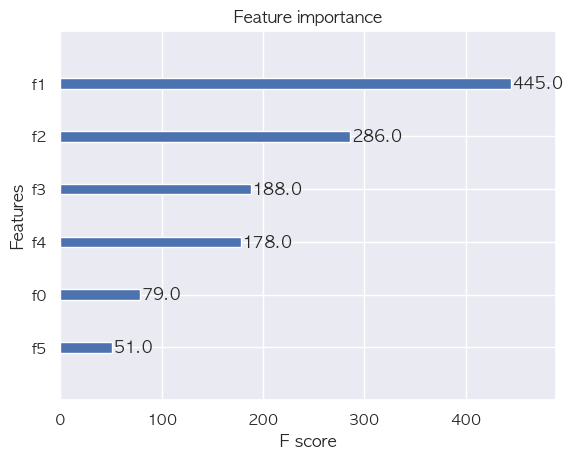

In [611]:
plot_importance(xgboost)

In [612]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train_standardized, y_train)
cb.score(X_test_standardized, y_test)

Learning rate set to 0.046193
0:	learn: 2808.5443190	total: 934us	remaining: 934ms
1:	learn: 2739.8912072	total: 1.47ms	remaining: 735ms
2:	learn: 2676.4686808	total: 1.99ms	remaining: 661ms
3:	learn: 2623.7461495	total: 2.31ms	remaining: 576ms
4:	learn: 2568.0256155	total: 2.72ms	remaining: 541ms
5:	learn: 2518.4018851	total: 3.22ms	remaining: 534ms
6:	learn: 2469.9247521	total: 3.71ms	remaining: 526ms
7:	learn: 2424.5820187	total: 5.16ms	remaining: 639ms
8:	learn: 2377.8929584	total: 5.84ms	remaining: 643ms
9:	learn: 2334.3179160	total: 6.33ms	remaining: 627ms
10:	learn: 2295.6534273	total: 6.82ms	remaining: 613ms
11:	learn: 2260.9624734	total: 7.37ms	remaining: 607ms
12:	learn: 2226.8980158	total: 7.85ms	remaining: 596ms
13:	learn: 2190.3235208	total: 8.42ms	remaining: 593ms
14:	learn: 2159.3248454	total: 8.91ms	remaining: 585ms
15:	learn: 2129.0556178	total: 9.4ms	remaining: 578ms
16:	learn: 2101.6509461	total: 9.91ms	remaining: 573ms
17:	learn: 2074.3494719	total: 10.4ms	remaining

0.6639086157345726

## 데이터시각화

In [575]:
corr = gajwa_data.corr()
corr

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전세전환가격
도로조건,1.000000,0.003002,-0.104286,0.245077,0.042160,0.047291,-0.047291,0.176671
계약면적(㎡),0.003002,1.000000,-0.093352,-0.202356,0.089829,-0.012119,0.012119,0.392502
건축년도,-0.104286,-0.093352,1.000000,0.142690,-0.028468,-0.101014,0.101014,-0.001156
year,0.245077,-0.202356,0.142690,1.000000,-0.032791,-0.026964,0.026964,0.240234
month,0.042160,0.089829,-0.028468,-0.032791,1.000000,-0.040222,0.040222,0.041322
전월세구분_월세,0.047291,-0.012119,-0.101014,-0.026964,-0.040222,1.000000,-1.000000,0.476071
전월세구분_전세,-0.047291,0.012119,0.101014,0.026964,0.040222,-1.000000,1.000000,-0.476071
전세전환가격,0.176671,0.392502,-0.001156,0.240234,0.041322,0.476071,-0.476071,1.000000


## 카카오맵api